In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gc
import sys
from statsmodels.formula.api import ols
from IPython.display import clear_output
from numba import njit, jit

In [2]:
df = pd.read_csv('SALES_2019.csv', parse_dates=['Date'])

In [3]:
df

,SKU_ID,Store_ID,Date,Demand,Regular_Price
0,114,1078,2019-01-01,2.0,51.0
1,114,1078,2019-01-02,2.0,51.0
2,114,1078,2019-01-03,2.0,51.0
3,114,1078,2019-01-04,2.0,51.0
4,114,1078,2019-01-05,2.0,51.0
...,...,...,...,...,...
75549757,363971,2866,2019-12-25,2.0,104.0
75549758,363971,2866,2019-12-26,2.0,104.0
75549759,363971,2866,2019-12-27,2.0,104.0
75549760,363971,2866,2019-12-28,2.0,104.0


<AxesSubplot:xlabel='Date'>

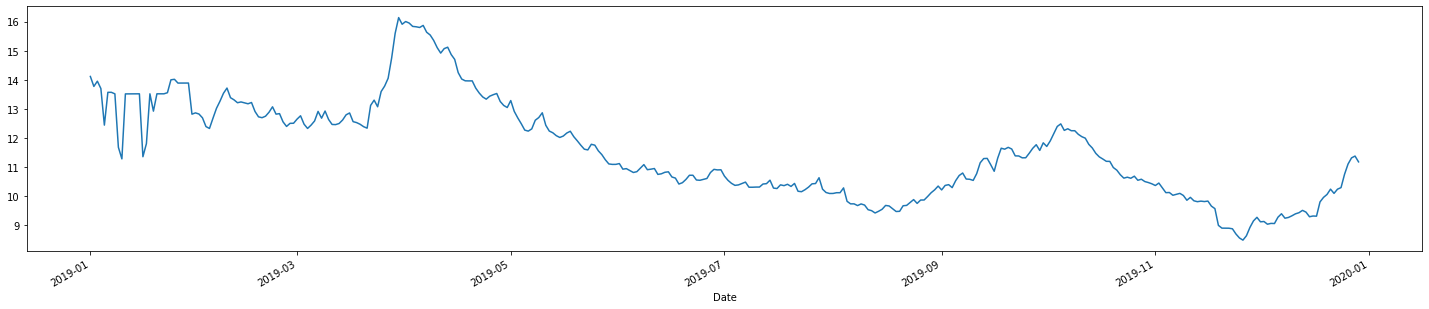

In [66]:
df.groupby('Date').mean()['Demand'].plot(figsize=(25, 5))

In [4]:
df = df[df.Demand > 0]
df

,SKU_ID,Store_ID,Date,Demand,Regular_Price
0,114,1078,2019-01-01,2.0,51.0
1,114,1078,2019-01-02,2.0,51.0
2,114,1078,2019-01-03,2.0,51.0
3,114,1078,2019-01-04,2.0,51.0
4,114,1078,2019-01-05,2.0,51.0
...,...,...,...,...,...
75549757,363971,2866,2019-12-25,2.0,104.0
75549758,363971,2866,2019-12-26,2.0,104.0
75549759,363971,2866,2019-12-27,2.0,104.0
75549760,363971,2866,2019-12-28,2.0,104.0


In [5]:
popular_pairs = df.groupby(['SKU_ID', 'Store_ID']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)

In [6]:
popular_pairs.head(n=10)

,SKU_ID,Store_ID,counts
0,121403,2834,361
1,14408,2834,361
2,150862,2834,361
3,213851,2834,361
4,93788,2834,361
5,137749,1855,361
6,149856,2676,361
7,93788,2711,361
8,4240,1498,361
9,93788,2710,361


In [8]:
popular_pairs.head(n=100000).tail(n=1)

,SKU_ID,Store_ID,counts
99999,23080,1504,340


In [9]:
num_of_pairs = 100000
pairs_for_experiment = [0 for _ in range(num_of_pairs)]
for i, r in popular_pairs.iterrows():
    if i == num_of_pairs:
        break
    pairs_for_experiment[i] = (r['SKU_ID'], r['Store_ID'])

In [15]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [16]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [17]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [18]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [19]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [34]:
def GeneratePEDModels(dataset):
    model_type = 'log-log'
    sku_id, store_id, elas, qty, ttpvalue, price, q1_elas = [], [], [], [], [], [], []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.Store_ID == shop_id) & (dataset.SKU_ID == good_id)]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

        sku_id.append(good_id)
        store_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        
        # 2019 Q1
        data = data[(data.Date >= '2019-01-01') & (data.Date <= '2019-03-31')]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)
        
        qty.append(data.Demand.sum() / data.shape[0])
        price.append(data.Regular_Price.sum() / data.shape[0])
        q1_elas.append(e)
        
        clear_output()
        print(iter_count)
        iter_count += 1
        
        if iter_count == 30000:
            break
        
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Elasticity': elas,
        'P_value': ttpvalue,
        'Q1_Qty': qty,
        'Q1_Price': price,
        'Q1_Elasticity': q1_elas,
    })

In [35]:
trained_data = GeneratePEDModels(df)

29999


In [36]:
trained_data

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity
0,121403,2834,4.947777e+00,1.387119e-91,203.211111,219.056926,2.499524e-01
1,14408,2834,-1.248910e+00,2.932442e-61,202.344444,60.457444,-3.693639e+00
2,150862,2834,-1.006074e+00,2.219744e-64,266.366667,301.042889,-1.490706e+00
3,213851,2834,-1.328601e+00,5.668468e-03,4141.500000,90.424887,-5.872169e-01
4,93788,2834,1.314355e+00,9.124566e-86,206.511111,495.959667,1.156394e+00
...,...,...,...,...,...,...,...
29995,2010,1104,8.609657e+00,1.382582e-10,2.930233,389.313953,3.194009e+00
29996,14978,2231,9.933930e-02,1.456373e-06,1.905882,281.152941,-7.351222e-02
29997,147136,2232,-1.346145e-15,9.605337e-01,1.000000,146.640449,7.771561e-15
29998,118617,1118,9.419250e-02,6.148370e-01,1.377778,283.422222,1.273333e+01


In [37]:
trained_data.to_csv('DF_TRAIN.csv', index=False)

In [2]:
trained_data = pd.read_csv('DF_TRAIN.csv')

In [38]:
df_train = trained_data[(trained_data.Elasticity > -10) & (trained_data.Elasticity < 0) & (trained_data.P_value < 0.05)]

In [39]:
df_train

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity
1,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00
2,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00
3,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01
6,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15
8,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01
...,...,...,...,...,...,...,...
29988,13154,1093,-4.951978,4.565353e-53,11.733333,80.611111,-6.440381e+00
29989,18086,1110,-4.119013,2.907439e-35,20.844444,289.488889,-6.259203e+00
29991,97331,1132,-0.203404,1.443094e-06,1.188889,345.000000,1.316588e-01
29994,18086,1108,-6.240736,1.938132e-24,29.639535,323.627907,1.860400e+01


In [158]:
product_info = pd.read_csv('PRODUCT_INF.csv')

In [159]:
product_info

,ProductName,SKU,ClassId,GroupId,SubGroupId,CategoryId,ClusterId,Class,Groups,SubGroups,Category,Cluster
0,UN,9999999,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
1,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122139,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
2,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122140,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
3,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122141,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
4,Очки_x0020_корригирующие_x0020_Dali_x0020_плас...,122142,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
...,...,...,...,...,...,...,...,...,...,...,...,...
296388,Лактамил_x0020_смесь_x0020_сухая_x0020_молочна...,112785,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296389,Чай_x0020__x0022_Хипп_x0022__x0020_с_x0020_вит...,112789,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296390,Чай_x0020_Хипп_x0020_био_x0020_для_x0020_корм....,76810,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296391,Фемилак_x0020_для_x0020_беременных_x0020_и_x00...,75619,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам


In [160]:
product_info = product_info[['SKU', 'ClassId', 'CategoryId', 'ClusterId', 'GroupId', 'SubGroupId']]

In [161]:
df_sku = df_train.join(product_info.set_index('SKU'), on='SKU')

In [162]:
df_sku.isna().sum()

SKU               0
Store             0
Elasticity        0
P_value           0
Q1_Qty            0
Q1_Price          0
Q1_Elasticity     0
ClassId          55
CategoryId       55
ClusterId        55
GroupId          55
SubGroupId       55
dtype: int64

In [163]:
df_sku.dropna(inplace=True)

In [164]:
df_sku.isna().sum()

SKU              0
Store            0
Elasticity       0
P_value          0
Q1_Qty           0
Q1_Price         0
Q1_Elasticity    0
ClassId          0
CategoryId       0
ClusterId        0
GroupId          0
SubGroupId       0
dtype: int64

In [165]:
df_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,ClassId,CategoryId,ClusterId,GroupId,SubGroupId
1,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,2003.0,2561.0,27.0,2047.0,2356.0
2,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,2003.0,2547.0,4.0,2047.0,2099.0
3,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,2003.0,2496.0,456.0,2037.0,2105.0
6,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,2003.0,3023.0,458.0,2037.0,2105.0
8,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,2003.0,2692.0,455.0,2037.0,2105.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29988,13154,1093,-4.951978,4.565353e-53,11.733333,80.611111,-6.440381e+00,2003.0,2489.0,467.0,2037.0,2111.0
29989,18086,1110,-4.119013,2.907439e-35,20.844444,289.488889,-6.259203e+00,2003.0,2711.0,39.0,2047.0,2151.0
29991,97331,1132,-0.203404,1.443094e-06,1.188889,345.000000,1.316588e-01,2003.0,2528.0,34.0,2047.0,2212.0
29994,18086,1108,-6.240736,1.938132e-24,29.639535,323.627907,1.860400e+01,2003.0,2711.0,39.0,2047.0,2151.0


In [167]:
store_info = pd.read_excel('LOCATION_INF.xlsx', parse_dates=['OpenDate', 'CloseDate'])
store_info.rename(columns={'TradePointId': 'Store'}, inplace=True)

In [168]:
import datetime

age_func = lambda r: datetime.datetime.today().year - datetime.datetime.date(r).year
store_info['StoreAge'] = store_info.OpenDate.apply(age_func)

In [169]:
def city_func(r):
    city = r.split('_x0020_')[0]
    if city.endswith('_x002C_'):
        city = city.split('_x002C_')[0]

    return city

store_info['StoreCity'] = store_info.TradePointName.apply(city_func)

In [170]:
store_info = store_info[['Store', 'StoreAge', 'StoreCity']]

In [171]:
store_info

,Store,StoreAge,StoreCity
0,1076,12,СПб
1,1077,16,СПб
2,1078,14,СПб
3,1079,19,СПб
4,1080,13,СПб
...,...,...,...
179,2926,1,СПб
180,2928,1,СПб
181,2930,1,Интернет-магазин
182,2952,1,СПб


In [172]:
df_store_sku = df_sku.join(store_info.set_index('Store'), on='Store')

In [173]:
df_store_sku.isna().sum()

SKU               0
Store             0
Elasticity        0
P_value           0
Q1_Qty            0
Q1_Price          0
Q1_Elasticity     0
ClassId           0
CategoryId        0
ClusterId         0
GroupId           0
SubGroupId        0
StoreAge         57
StoreCity        57
dtype: int64

In [174]:
df_store_sku.dropna(inplace=True)

In [175]:
df_store_sku.isna().sum()

SKU              0
Store            0
Elasticity       0
P_value          0
Q1_Qty           0
Q1_Price         0
Q1_Elasticity    0
ClassId          0
CategoryId       0
ClusterId        0
GroupId          0
SubGroupId       0
StoreAge         0
StoreCity        0
dtype: int64

In [176]:
from sklearn.preprocessing import LabelEncoder

df_store_sku.StoreCity = LabelEncoder().fit_transform(df_store_sku.StoreCity)

In [177]:
df_store_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,ClassId,CategoryId,ClusterId,GroupId,SubGroupId,StoreAge,StoreCity
1,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,2003.0,2561.0,27.0,2047.0,2356.0,2.0,2
2,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,2003.0,2547.0,4.0,2047.0,2099.0,2.0,2
3,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,2003.0,2496.0,456.0,2037.0,2105.0,2.0,2
6,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,2003.0,3023.0,458.0,2037.0,2105.0,3.0,3
8,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,2003.0,2692.0,455.0,2037.0,2105.0,17.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29988,13154,1093,-4.951978,4.565353e-53,11.733333,80.611111,-6.440381e+00,2003.0,2489.0,467.0,2037.0,2111.0,9.0,5
29989,18086,1110,-4.119013,2.907439e-35,20.844444,289.488889,-6.259203e+00,2003.0,2711.0,39.0,2047.0,2151.0,6.0,5
29991,97331,1132,-0.203404,1.443094e-06,1.188889,345.000000,1.316588e-01,2003.0,2528.0,34.0,2047.0,2212.0,4.0,5
29994,18086,1108,-6.240736,1.938132e-24,29.639535,323.627907,1.860400e+01,2003.0,2711.0,39.0,2047.0,2151.0,6.0,5


In [183]:
X = df_store_sku[['SKU', 'Store', 'ClassId', 'CategoryId', 'ClusterId', 'StoreAge', 'StoreCity', 'Q1_Qty', 'Q1_Price', 'Q1_Elasticity']].to_numpy()
y = df_store_sku['Elasticity'].to_numpy()

In [184]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [185]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg = RandomForestRegressor().fit(X_train, y_train)

In [186]:
mean_squared_error(y_test, reg.predict(X_test))

3.0398959023505774

Text(0, 0.5, 'True value')

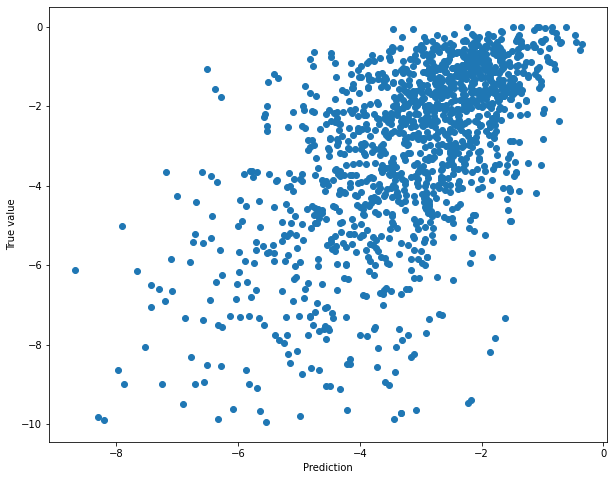

In [187]:
plt.figure(figsize=(10, 8))
plt.plot(reg.predict(X_test), y_test, 'o')
plt.xlabel('Prediction')
plt.ylabel('True value')

In [188]:
X_train.shape

(12157, 10)